In [1]:
from param import Param
from sde import *
from fparam import *
import numpy as np

In [25]:
# Euler's Discretization
params = {
    "C_mu": Param(.8),
    "C_v" : Param(1.6),
}

def f_mu(S_t, t, params=None):
    return S_t * params["C_mu"].eval()

def f_v(S_t, t, params=None):
    return S_t * params["C_v"].eval()

mu  = FParam(f_mu, params)
v   = FParam(f_mu, params)
S_0 = Param(100)
T   = 252
dt  = Param(0.01)
N   = 20

simulation = EulerSimulation(mu, v, S_0, T, dt, N)

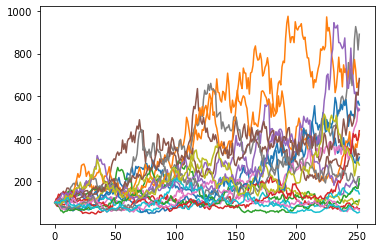

In [26]:
from matplotlib import pyplot as plt

simulation.run_all()
for i in range(N):
    plt.plot(simulation.results[:, i])
plt.show()

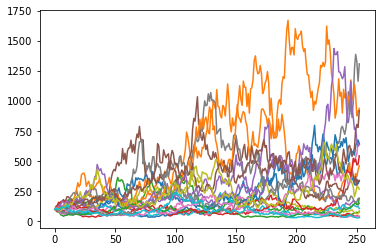

In [27]:
params["C_mu"].val = 1.1
simulation.run_all()
for i in range(N):
    plt.plot(simulation.results[:, i])
plt.show()

In [30]:
# Log Euler's Discretization
def f_mu(S_t, t, params=None):
    return params["C_mu"].eval()

def f_v(S_t, t, params=None):
    return params["C_v"].eval()

mu  = FParam(f_mu, params)
v   = FParam(f_mu, params)
S_0 = Param(100)
T   = 252
dt  = Param(0.01)
N   = 20

simulation = EulerSimulation(mu, v, S_0, T, dt, N, param=LogEulerParam)
simulation.run_all()

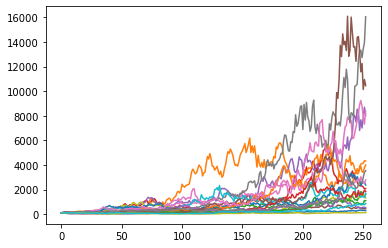

In [34]:
from matplotlib import pyplot as plt

for i in range(N):
    plt.plot(simulation.results[:, i])
plt.show()